In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip /content/drive/My\ Drive/ai/cat_dog.zip 

In [0]:
!rm -rf /content/train /content/val /content/test

In [0]:
# 导入开发需要的库
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import numpy as np
from tqdm import tqdm
import cv2

In [0]:
np.random.seed(2019)

n = 20000
X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range(n//2)):
    X[i] = cv2.resize(cv2.imread("/content/train/cat_%d.jpg" % i), (224, 224))
    X[i+n//2] = cv2.resize(cv2.imread("/content/train/dog_%d.jpg" % i), (224, 224))
y[n//2:] = 1

100%|██████████| 10000/10000 [03:10<00:00, 47.21it/s]


In [0]:
X[0].shape

(224, 224, 3)

In [0]:
y[0]

array([0], dtype=uint8)

[0]


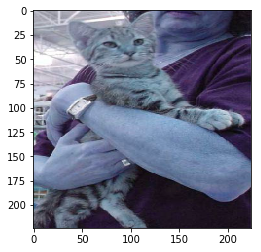

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[0])
print(y[0])

In [0]:
# 分为训练集和验证集
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2)

### ResNet50模型

In [211]:
base_model = ResNet50(input_tensor=Input((224,224,3)),weights="imagenet",include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1,activation="sigmoid")(x)

model = Model(base_model.input,x)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
 model.compile(optimizer="adam",
               loss="binary_crossentropy",
               metrics=["accuracy"])

In [213]:
rc = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=2,
                               verbose=1,
                               min_delta=1e-4,
                               mode='min')
model_name =  'resnet.hdf5'
mc = ModelCheckpoint(model_name, 
                         monitor='val_loss', 
                         save_best_only=True,
                         mode='min')
model.fit(X_train,
          y_train,
          batch_size=64,
          verbose = 1,
          epochs=15,
          validation_data=(X_valid,y_valid),
          callbacks=[mc, rc])

Train on 16000 samples, validate on 4000 samples
Epoch 1/15
16000/16000 [==============================] - 83s 5ms/step - loss: 0.1504 - acc: 0.9396 - val_loss: 0.0708 - val_acc: 0.9718
Epoch 2/15
16000/16000 [==============================] - 74s 5ms/step - loss: 0.0648 - acc: 0.9766 - val_loss: 0.0639 - val_acc: 0.9760
Epoch 3/15
16000/16000 [==============================] - 74s 5ms/step - loss: 0.0559 - acc: 0.9798 - val_loss: 0.0539 - val_acc: 0.9778
Epoch 4/15
16000/16000 [==============================] - 74s 5ms/step - loss: 0.0555 - acc: 0.9798 - val_loss: 0.0592 - val_acc: 0.9775
Epoch 5/15
16000/16000 [==============================] - 74s 5ms/step - loss: 0.0482 - acc: 0.9824 - val_loss: 0.0599 - val_acc: 0.9775

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/15
16000/16000 [==============================] - 75s 5ms/step - loss: 0.0481 - acc: 0.9824 - val_loss: 0.0622 - val_acc: 0.9758
Epoch 7/15
16000/16000 [========================

In [0]:
for i,layer in enumerate(model.layers):
  print(i,layer)

In [214]:
#微调
rc = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=2,
                               verbose=1,
                               min_delta=1e-4,
                               mode='min')
model_name =  'resnet.hdf5'
mc = ModelCheckpoint(model_name, 
                         monitor='val_loss', 
                         save_best_only=True,
                         mode='min')

for layer in model.layers[140:]:
    layer.trainable = True
model.fit(X_train, 
          y_train, 
          batch_size=64, 
          verbose = 1,
          epochs=5, 
          validation_data=(X_valid, y_valid),
          callbacks=[mc, rc])


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 74s 5ms/step - loss: 0.0386 - acc: 0.9854 - val_loss: 0.0630 - val_acc: 0.9755
Epoch 2/5
16000/16000 [==============================] - 74s 5ms/step - loss: 0.0378 - acc: 0.9861 - val_loss: 0.0618 - val_acc: 0.9762
Epoch 3/5
16000/16000 [==============================] - 74s 5ms/step - loss: 0.0376 - acc: 0.9863 - val_loss: 0.0632 - val_acc: 0.9758
Epoch 4/5
16000/16000 [==============================] - 74s 5ms/step - loss: 0.0376 - acc: 0.9872 - val_loss: 0.0620 - val_acc: 0.9762

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 5/5
16000/16000 [==============================] - 74s 5ms/step - loss: 0.0375 - acc: 0.9854 - val_loss: 0.0633 - val_acc: 0.9758


In [0]:
model.save_weights("resnet.h5")

In [0]:
model.load_weights("resnet.hdf5")

In [0]:
m = 2000
X_test = np.zeros((m,224,224,3),dtype=np.uint8)
for i in tqdm(range(m)):
    X_test[i] = cv2.resize(cv2.imread("/content/test/%d.jpg"% i),(224,224))

100%|██████████| 2000/2000 [00:03<00:00, 545.41it/s]


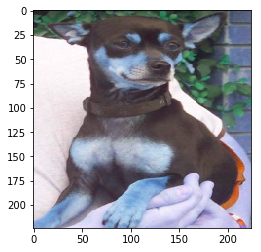

In [0]:
plt.imshow(X_test[1])

In [0]:
y_pred = model.predict(X_test)

In [217]:
y_pred

array([[1.7881393e-06],
       [9.9975282e-01],
       [9.9998498e-01],
       ...,
       [3.2782555e-07],
       [6.7055225e-06],
       [9.9999881e-01]], dtype=float32)

In [218]:
print(y_pred[:10])

[[1.7881393e-06]
 [9.9975282e-01]
 [9.9998498e-01]
 [3.5762787e-07]
 [3.7601352e-02]
 [9.9999994e-01]
 [2.9057264e-05]
 [1.0000000e+00]
 [9.9999940e-01]
 [9.9973840e-01]]


In [0]:
for i in range(m):
    if y_pred[i] > 0.6:
        y_pred[i] = 1;
    else:
        y_pred[i] = 0;

In [220]:
y_pred[:10]

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [0]:
id = np.arange(0,2000)

In [222]:
id.shape

(2000,)

In [0]:
import pandas as pd

df = pd.DataFrame({"id":id, "predict":y_pred[:,0]})
df.to_csv("resnet_submit.csv",index=None)

### VGG16

### VGG16模型

In [0]:
base_model = VGG16(input_tensor=Input((224,224,3)),weights="imagenet",include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1,activation="sigmoid")(x)

model = Model(base_model.input,x)

In [0]:
 model.compile(optimizer="adam",
               loss="binary_crossentropy",
               metrics=["accuracy"])

In [192]:
rc = ReduceLROnPlateau(monitor='val_acc',
                               factor=0.5,
                               patience=2,
                               verbose=1,
                               min_delta=1e-4,
                               mode='max')
model_name = 'vgg16.hdf5'
mc = ModelCheckpoint(model_name, 
                         monitor='val_acc', 
                         save_best_only=True,
                         mode='max')
  
history_fit = model.fit(X_train,
                        y_train,
                        batch_size=64,
                        verbose = 1,
                        epochs=15,
                        validation_data=(X_valid,y_valid),
                        callbacks=[mc, rc])

Train on 16000 samples, validate on 4000 samples
Epoch 1/15
16000/16000 [==============================] - 100s 6ms/step - loss: 0.5829 - acc: 0.8830 - val_loss: 0.1440 - val_acc: 0.9620
Epoch 2/15
16000/16000 [==============================] - 95s 6ms/step - loss: 0.1882 - acc: 0.9511 - val_loss: 0.1079 - val_acc: 0.9695
Epoch 3/15
16000/16000 [==============================] - 95s 6ms/step - loss: 0.1329 - acc: 0.9614 - val_loss: 0.0942 - val_acc: 0.9722
Epoch 4/15
16000/16000 [==============================] - 95s 6ms/step - loss: 0.1109 - acc: 0.9670 - val_loss: 0.0971 - val_acc: 0.9725
Epoch 5/15
16000/16000 [==============================] - 95s 6ms/step - loss: 0.0984 - acc: 0.9676 - val_loss: 0.0795 - val_acc: 0.9755
Epoch 6/15
16000/16000 [==============================] - 95s 6ms/step - loss: 0.0872 - acc: 0.9716 - val_loss: 0.0774 - val_acc: 0.9760
Epoch 7/15
16000/16000 [==============================] - 95s 6ms/step - loss: 0.0786 - acc: 0.9729 - val_loss: 0.0759 - val_acc

In [193]:
for i,layer in enumerate(model.layers):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
  print(i,layer)

0 <keras.engine.input_layer.InputLayer object at 0x7ff7daebc080>
1 <keras.layers.convolutional.Conv2D object at 0x7ff7daebc358>
2 <keras.layers.convolutional.Conv2D object at 0x7ff7daead4a8>
3 <keras.layers.pooling.MaxPooling2D object at 0x7ff7daf07ac8>
4 <keras.layers.convolutional.Conv2D object at 0x7ff7db05b128>
5 <keras.layers.convolutional.Conv2D object at 0x7ff7daee1668>
6 <keras.layers.pooling.MaxPooling2D object at 0x7ff7dae76e10>
7 <keras.layers.convolutional.Conv2D object at 0x7ff7dae76470>
8 <keras.layers.convolutional.Conv2D object at 0x7ff7daea1128>
9 <keras.layers.convolutional.Conv2D object at 0x7ff7dae35c50>
10 <keras.layers.pooling.MaxPooling2D object at 0x7ff7dae4ab38>
11 <keras.layers.convolutional.Conv2D object at 0x7ff7dae4ae48>
12 <keras.layers.convolutional.Conv2D object at 0x7ff7dadf75f8>
13 <keras.layers.convolutional.Conv2D object at 0x7ff7dae0f630>
14 <keras.layers.pooling.MaxPooling2D object at 0x7ff7dae20b38>
15 <keras.layers.convolutional.Conv2D object at 

In [195]:
#微调
rc = ReduceLROnPlateau(monitor='val_acc',
                               factor=0.5,
                               patience=2,
                               verbose=1,
                               min_delta=1e-4,
                               mode='max')
model_name = 'vgg16.hdf5'
mc = ModelCheckpoint(model_name, 
                         monitor='val_acc', 
                         save_best_only=True,
                         mode='max')
for layer in model.layers[14:]:
    layer.trainable = True
model.fit(X_train, 
          y_train, 
          batch_size=64, 
          verbose = 1,
          epochs=5, 
          validation_data=(X_valid, y_valid),
          callbacks=[mc, rc])


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 94s 6ms/step - loss: 0.0599 - acc: 0.9772 - val_loss: 0.0618 - val_acc: 0.9798
Epoch 2/5
16000/16000 [==============================] - 94s 6ms/step - loss: 0.0605 - acc: 0.9768 - val_loss: 0.0618 - val_acc: 0.9788
Epoch 3/5
16000/16000 [==============================] - 95s 6ms/step - loss: 0.0614 - acc: 0.9775 - val_loss: 0.0641 - val_acc: 0.9780

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 4/5
16000/16000 [==============================] - 95s 6ms/step - loss: 0.0588 - acc: 0.9771 - val_loss: 0.0605 - val_acc: 0.9790
Epoch 5/5
16000/16000 [==============================] - 95s 6ms/step - loss: 0.0601 - acc: 0.9775 - val_loss: 0.0602 - val_acc: 0.9785

Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


In [0]:
model.save_weights("vgg16.h5")

In [0]:
model.load_weights("vgg16.hdf5")

In [0]:
y_pred = model.predict(X_test)

In [0]:
for i in range(m):
    if y_pred[i] > 0.6:
        y_pred[i] = 1;
    else:
        y_pred[i] = 0;

In [0]:
id = np.arange(0,2000)

In [0]:
import pandas as pd

df = pd.DataFrame({"id":id, "predict":y_pred[:,0]})
df.to_csv("vgg_submit.csv",index=None)

mv: cannot stat 'vgg_submit.csv': No such file or directory


### 模型结果融合

In [0]:
import pandas as pd

resnet_submit = "./5.csv"
vgg_submit = "./vgg_submit.csv"

df1 = pd.read_csv(resnet_submit)
df2 = pd.read_csv(vgg_submit)

df1_predict = df1["predict"]
df2_predict = df2["predict"]



In [230]:
df1_predict.head()


0    0.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: predict, dtype: float64

In [231]:
df2_predict.head()

0    0.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: predict, dtype: float64

In [232]:
print(len(df1_predict))

2000


In [233]:
for i in range(len(df1_predict)):
  if df1_predict[i]!=df2_predict[i]:
    print(i,df1_predict[i],df2_predict[i])

20 0.0 1.0
43 1.0 0.0
175 0.0 1.0
177 0.0 1.0
190 0.0 1.0
195 0.0 1.0
208 0.0 1.0
255 0.0 1.0
256 0.0 1.0
328 0.0 1.0
357 0.0 1.0
378 0.0 1.0
411 0.0 1.0
445 1.0 0.0
565 0.0 1.0
594 0.0 1.0
597 1.0 0.0
642 0.0 1.0
737 0.0 1.0
749 0.0 1.0
762 0.0 1.0
814 1.0 0.0
844 0.0 1.0
908 1.0 0.0
966 0.0 1.0
988 0.0 1.0
992 0.0 1.0
1000 0.0 1.0
1047 0.0 1.0
1054 0.0 1.0
1074 0.0 1.0
1159 1.0 0.0
1182 1.0 0.0
1183 1.0 0.0
1203 1.0 0.0
1346 1.0 0.0
1383 1.0 0.0
1395 0.0 1.0
1397 0.0 1.0
1453 0.0 1.0
1492 0.0 1.0
1543 0.0 1.0
1669 0.0 1.0
1749 1.0 0.0
1758 0.0 1.0
1768 1.0 0.0
1791 1.0 0.0
1833 1.0 0.0
1885 0.0 1.0
1908 0.0 1.0
1920 1.0 0.0
1977 0.0 1.0
